In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import re
import string
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob
from sklearn.metrics import confusion_matrix, f1_score
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import gensim
from gensim.models import CoherenceModel
from gensim.models.phrases import Phrases
import nltk
from nltk.collections import *
from nltk import FreqDist, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import pyLDAvis
import pyLDAvis.gensim
from wordcloud import WordCloud
plt.rcParams['figure.dpi'] = 300
sns.set(rc={"figure.dpi":500, 'savefig.dpi':500})
%matplotlib inline

In [389]:
cs1 = pd.read_csv('delighted-data_4-March-2021.csv')
cs1.columns

Index(['Response ID', 'Name', 'Email', 'Score', 'Comment',
       'Response Timestamp', 'Notes', 'Tags', 'mobile app',
       'new digital self-service customer experience', 'online web portal',
       'Which area(s) do you feel need improvement?', 'additional feedback ',
       'becoming a part of a focus group', 'Country', 'CustomerNumber',
       'Delighted Browser', 'Delighted Device Type', 'Delighted Email Subject',
       'Delighted Intro Message', 'Delighted Operating System',
       'Delighted Source', 'FirstName', 'GivenName', 'Inbounds', 'LastName',
       'Name.1', 'Outbounds', 'Phone', 'PolicyDisplayNumber', 'Policy Number',
       'PolicyRef', 'PolicyType', 'Total_Calls', 'UncorrectedName'],
      dtype='object')

In [132]:
cs = pd.read_csv('delighted-data_4-March-2021.csv', usecols=[0, 1, 2, 3, 4, 12])
cs = cs[['Response ID', 'Name', 'Email', 'Comment', 'additional feedback ', 'Score']]
cs.columns = ['Response ID', 'Name', 'Email', 'Comment', 'Additional', 'Score']
cs.head()

,Response ID,Name,Email,Comment,Additional,Score
0,164883233,Lillian Boyd,tygjhs@verizon.net,NaN,NaN,4
1,164882060,Evelyn McGovern,treehugger1492@gmail.com,NaN,NaN,5
2,164874532,Angela Rowe,angela@surfcitytravel.com,"i prefer to speak to a person,Especially when ...",NaN,3
3,164872927,Phyllis,phyllis.wilson51@yahoo.com,Knowledgeable and professional,NaN,5
4,164868116,Patricia Brown,trishbrown43@yahoo.com,I cancelled Petplan so this does not apply to ...,NaN,3


In [133]:
cs['Comment'] = cs.Comment.str.replace('[\n\t]', "", regex = True)
cs['Additional'] = cs.Additional.str.replace('[\n\t]', "", regex = True)
# cs.Comment = cs.Comment.astype('str')
cs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1422 entries, 0 to 1421
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Response ID  1422 non-null   int64 
 1   Name         1422 non-null   object
 2   Email        1422 non-null   object
 3   Comment      743 non-null    object
 4   Additional   303 non-null    object
 5   Score        1422 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 66.8+ KB


In [131]:
if pd.notna(cs.Comment[0]):
    print('yes')

In [134]:
cs['reviews'] = cs.apply(lambda x: x['Comment'] + ' ' + x['Additional'] if (pd.notna(x['Comment']) and pd.notna(x['Additional'])) else x['Comment'] if pd.notna(x['Comment']) else None, axis = 1)
cs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1422 entries, 0 to 1421
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Response ID  1422 non-null   int64 
 1   Name         1422 non-null   object
 2   Email        1422 non-null   object
 3   Comment      743 non-null    object
 4   Additional   303 non-null    object
 5   Score        1422 non-null   int64 
 6   reviews      743 non-null    object
dtypes: int64(2), object(5)
memory usage: 77.9+ KB


In [138]:
cs.drop_duplicates(keep='first', inplace=True, ignore_index=True)
cs[cs.duplicated(keep=False)]

,Response ID,Name,Email,Comment,Additional,Score,reviews


In [14]:
from transformers import pipeline
nlp=pipeline('sentiment-analysis', model='nlptown/bert-base-multilingual-uncased-sentiment')

In [208]:
nlp('customer service is absolutely horrible.')[0]

{'label': '1 star', 'score': 0.930723249912262}

In [140]:
to_sents = spacy.load("en_core_web_sm")
spacy_text_blob = SpacyTextBlob()
to_sents.add_pipe(spacy_text_blob)
star_senti = {'1 star':'Negative', '2 stars': 'Negative', '3 stars': 'Neutral', '4 stars': 'Positive', '5 stars': 'Positive'}
class trans_bert_score(object):
            
    def score_by_sentence(self, text):
        self.text = text
        self.sent_bert_label = {}
        sentences = to_sents(self.text)
        sents = [str(s).strip().lower() for s in sentences.sents]
        for i in sents:
            doc = nlp(i)
            self.sent_bert_label[i] = star_senti[doc[0]['label']]
        return self.sent_bert_label
    def label_bert_by_reviews(self, text):
        if text:
            doc = nlp(text[:1028])
            return doc[0]['label'] 

In [142]:
classifier = trans_bert_score()
cs['transformer_rating'] = cs.reviews.apply(lambda x: classifier.label_bert_by_reviews(x))

In [145]:
num_senti = {'1 star':'Negative', '2 stars': 'Negative', '3 stars': 'Neutral', '4 stars': 'Positive', '5 stars': 'Positive'}
cs['transformer_label'] = cs.transformer_rating.apply(lambda x: num_senti[x] if x else None)
cs.head()

,Response ID,Name,Email,Comment,Additional,Score,reviews,transformer_rating,transformer_label
0,164883233,Lillian Boyd,tygjhs@verizon.net,NaN,NaN,4,None,None,None
1,164882060,Evelyn McGovern,treehugger1492@gmail.com,NaN,NaN,5,None,None,None
2,164874532,Angela Rowe,angela@surfcitytravel.com,"i prefer to speak to a person,Especially when ...",NaN,3,"i prefer to speak to a person,Especially when ...",2 stars,Negative
3,164872927,Phyllis,phyllis.wilson51@yahoo.com,Knowledgeable and professional,NaN,5,Knowledgeable and professional,5 stars,Positive
4,164868116,Patricia Brown,trishbrown43@yahoo.com,I cancelled Petplan so this does not apply to ...,NaN,3,I cancelled Petplan so this does not apply to ...,1 star,Negative


In [149]:
cs = cs[cs.reviews.notna()]
star_number = {'1 star': 1, '2 stars': 2, '3 stars': 3, '4 stars': 4, '5 stars': 5}
cs.transformer_rating = cs.transformer_rating.apply(lambda x: star_number[x])
cs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 743 entries, 2 to 1420
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Response ID         743 non-null    int64 
 1   Name                743 non-null    object
 2   Email               743 non-null    object
 3   Comment             743 non-null    object
 4   Additional          292 non-null    object
 5   Score               743 non-null    int64 
 6   reviews             743 non-null    object
 7   transformer_rating  743 non-null    int64 
 8   transformer_label   743 non-null    object
dtypes: int64(3), object(6)
memory usage: 58.0+ KB


In [150]:
cs.head()

,Response ID,Name,Email,Comment,Additional,Score,reviews,transformer_rating,transformer_label
2,164874532,Angela Rowe,angela@surfcitytravel.com,"i prefer to speak to a person,Especially when ...",NaN,3,"i prefer to speak to a person,Especially when ...",2,Negative
3,164872927,Phyllis,phyllis.wilson51@yahoo.com,Knowledgeable and professional,NaN,5,Knowledgeable and professional,5,Positive
4,164868116,Patricia Brown,trishbrown43@yahoo.com,I cancelled Petplan so this does not apply to ...,NaN,3,I cancelled Petplan so this does not apply to ...,1,Negative
6,164865553,Staci,stacierika@yahoo.com,"I called on Monday, and my issue has still not...",NaN,1,"I called on Monday, and my issue has still not...",1,Negative
7,164864099,Shawn,Mariegraves1995@gmail.com,i was charged when i wasnt supposed to\r,NaN,3,i was charged when i wasnt supposed to\r,1,Negative


In [152]:
classifier = trans_bert_score()
cs['transformer_label_sentence'] = cs.reviews.apply(lambda x: [classifier.score_by_sentence(x)])

In [161]:
cs.head()

,Response ID,Name,Email,Comment,Additional,Score,reviews,transformer_rating,transformer_label,transformer_label_sentence
2,164874532,Angela Rowe,angela@surfcitytravel.com,"i prefer to speak to a person,Especially when ...",NaN,3,"i prefer to speak to a person,Especially when ...",2,Negative,"[{'i prefer to speak to a person,especially wh..."
3,164872927,Phyllis,phyllis.wilson51@yahoo.com,Knowledgeable and professional,NaN,5,Knowledgeable and professional,5,Positive,[{'knowledgeable and professional': 'Positive'}]
4,164868116,Patricia Brown,trishbrown43@yahoo.com,I cancelled Petplan so this does not apply to ...,NaN,3,I cancelled Petplan so this does not apply to ...,1,Negative,[{'i cancelled petplan so this does not apply ...
6,164865553,Staci,stacierika@yahoo.com,"I called on Monday, and my issue has still not...",NaN,1,"I called on Monday, and my issue has still not...",1,Negative,"[{'i called on monday, and my issue has still ..."
7,164864099,Shawn,Mariegraves1995@gmail.com,i was charged when i wasnt supposed to\r,NaN,3,i was charged when i wasnt supposed to\r,1,Negative,[{'i was charged when i wasnt supposed to': 'N...


In [158]:
cs.to_csv('cs_after_sentiments')

In [392]:
df = pd.read_csv('cs_after_sentiments', index_col=0 )
df.head()

,Response ID,Name,Email,Comment,Additional,Score,reviews,transformer_rating,transformer_label,transformer_label_sentence
2,164874532,Angela Rowe,angela@surfcitytravel.com,"i prefer to speak to a person,Especially when ...",NaN,3,"i prefer to speak to a person,Especially when ...",2,Negative,"[{'i prefer to speak to a person,especially wh..."
3,164872927,Phyllis,phyllis.wilson51@yahoo.com,Knowledgeable and professional,NaN,5,Knowledgeable and professional,5,Positive,[{'knowledgeable and professional': 'Positive'}]
4,164868116,Patricia Brown,trishbrown43@yahoo.com,I cancelled Petplan so this does not apply to ...,NaN,3,I cancelled Petplan so this does not apply to ...,1,Negative,[{'i cancelled petplan so this does not apply ...
6,164865553,Staci,stacierika@yahoo.com,"I called on Monday, and my issue has still not...",NaN,1,"I called on Monday, and my issue has still not...",1,Negative,"[{'i called on monday, and my issue has still ..."
7,164864099,Shawn,Mariegraves1995@gmail.com,i was charged when i wasnt supposed to\r,NaN,3,i was charged when i wasnt supposed to\r,1,Negative,[{'i was charged when i wasnt supposed to': 'N...


In [400]:
call_back.to_csv('call_back.csv')

In [401]:
call_back = df[df.reviews.str.contains('call me back|call back|call me', flags = re.IGNORECASE, regex = True)]

In [405]:
for i,j in enumerate(call_back.reviews):
    print(f'{i+1}. ', j, '\n')

1.  I explain in detail my issue had been requesting a call from claims because I want them to explain denial of my claim again I was promised a call back within the next business date and it didn’t happen.  My claim was sent Aug of last year, re sent in November until my daughter help me to send it by app in Jan and I was told that it was denied coz I didn’t sent it within 90days?? I reply from that denial and it’s been 3 weeks I have not been replied or called until I made a personal call and still no reply???  I’ve been waiting for call back and explanation on why it’s been denied when it was Petplan that failed to reply on my claims and follow up even on a simple call back. 

2.  I requested a call back . I wanted to talk to a manager. Never happened.  I still want a. Call back. But you only want my money ,   Why can’t I get a call back ????? Call me back you assholes , have a manager call me after all the money I paid over the years I can’t even get you to return a phone call .  B

In [159]:
def text_preprocessing(text: list):
    nlp = spacy.load("en_core_web_sm")
    review_noun =[]
    
    text = [re.sub('\\S*@\\S*\\s?', '', sent) for sent in text]
    text = [re.sub('\\s+', ' ', sent) for sent in text]
    text = [re.sub("\\'", "", sent) for sent in text] 
    
    # only keep the nouns
    for review in text:
        noun = nlp(review)
        review_noun.append(' '.join([i.text for i in noun.noun_chunks]))
    print(review_noun[:5])
    # sentence to words
    review_words = []
    for sent in review_noun:
        review_words.append(gensim.utils.simple_preprocess(str(sent), deacc=True))
    print(review_words[:5])
    #remove numbers and lemmatization    
    docs = [[token for token in doc if not token.isnumeric()] for doc in review_words]
    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
    return docs  

In [179]:
def text_preprocessing2(text: list):
    nlp = spacy.load("en_core_web_sm")
    review_noun =[]
    
    text = [re.sub('\\S*@\\S*\\s?', '', sent) for sent in text]
    text = [re.sub('\\s+', ' ', sent) for sent in text]
    text = [re.sub("\\'", "", sent) for sent in text] 
    
    for review in text:
        sent = nlp(review)
        review_noun.append([token.lemma_ for token in sent if token.pos_ in ['NOUN', 'ADJ', 'VERB', 'ADV']])
    print(review_noun[:5])
#   sentence to words
    review_words = []
    for sent in review_noun:
        review_words.append(gensim.utils.simple_preprocess(str(sent), deacc=True))
    print(review_words[:5])
    #remove numbers and lemmatization    
    docs = [[token for token in doc if not token.isnumeric()] for doc in review_words]
    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
    return docs

In [344]:
reviews = cs.reviews.values.tolist()
reviews = [re.sub('\\S*@\\S*\\s?', '', sent) for sent in reviews]
reviews = [re.sub('\\s+', ' ', sent) for sent in reviews]
reviews = [re.sub("\\'", "", sent) for sent in reviews]
def reviews_to_words(reviews):
    for sent in reviews:
        yield(gensim.utils.simple_preprocess(str(sent), deacc=True))
list(reviews_to_words(['i like it', "I don't like it"]))
reviews_words = list(reviews_to_words(reviews))

In [345]:
bigrams = Phrases(reviews_words, min_count=1, threshold=10)
trigrams = Phrases(bigrams[reviews_words], min_count=1, threshold=10)
# bigrams.add_vocab(docs)
bigrams_mode = gensim.models.phrases.Phraser(bigrams)

In [347]:
trigrams['great_customer', 'service']

['great_customer_service']

In [166]:
reviews[:2]

['i prefer to speak to a person,Especially when I am paying $200.00 per month!',
 'Knowledgeable and professional ']

In [371]:
reviews = cs.reviews.values.tolist()
docs = text_preprocessing(reviews)
docs[:5]

['i a person I month', '', 'I Petplan me you', 'I my issue care My attorney a letter', 'i i']
[['person', 'month'], [], ['petplan', 'me', 'you'], ['my', 'issue', 'care', 'my', 'attorney', 'letter'], []]


[['person', 'month'],
 [],
 ['petplan', 'me', 'you'],
 ['my', 'issue', 'care', 'my', 'attorney', 'letter'],
 []]

In [1]:
stopwords_list = stopwords.words('english')
# stopwords_list.extend(['thats', 'fres', 'years', 'best', 'day', 'days','coin', 'coin_base', 'bit','coinbase',
#                            'time','would', 'week', 'anything', 'everything', 'nothing', 'lot'])
# "app", "petplan","company","will","day","much","I","It","even","t","review","time",
#                  "yesterday","This","pet","work","new","old","one","now","website","back","make","s","year"
#                  ,"way","try","anything","years","never","use","better","doesn","dont","week","star",'Claim','Customer'
#                   ,'Service','dog','Pet','pet','claims','w
final_docs = [[word for word in doc if word not in stopwords_list] for doc in docs]
final_docs = list(bigrams[final_docs])
final_docs = list(trigrams[final_docs])
final_docs = [[word for word in doc if word not in ['wa', 'fres', 'ha','dog','insurance','year', 'one', 'u', 'petplan', 
                                                    'plan','pet', 'pet_plan']] for doc in final_docs]

NameError: name 'stopwords' is not defined

In [373]:
x = []
for idx in range(len(final_docs)):
    for token in final_docs[idx]:
        if '_' in token:
            x.append(token)
freq_list = FreqDist(x)
print('\n-----------------')
freq_list.most_common(50)


-----------------


[('customer_service', 55),
 ('new_app', 16),
 ('new_website', 16),
 ('credit_card', 13),
 ('pet_insurance', 12),
 ('phone_call', 11),
 ('real_person', 10),
 ('long_time', 8),
 ('direct_deposit', 7),
 ('excellent_customer_service', 7),
 ('monthly_payment', 6),
 ('mobile_app', 6),
 ('web_site', 6),
 ('gift_card', 6),
 ('customer_service_representative', 5),
 ('new_system', 5),
 ('claim_submission', 5),
 ('old_system', 5),
 ('second_time', 5),
 ('great_customer_service', 5),
 ('customer_service_rep', 5),
 ('old_app', 5),
 ('old_website', 4),
 ('phone_number', 4),
 ('first_claim', 4),
 ('hard_time', 4),
 ('answering_service', 4),
 ('claim_process', 4),
 ('petplan_representative', 4),
 ('last_year', 3),
 ('good_service', 3),
 ('renewal_date', 3),
 ('new_way', 3),
 ('several_people', 3),
 ('existing_claim', 3),
 ('previous_version', 3),
 ('checking_account', 3),
 ('monthly_premium', 3),
 ('debit_card', 3),
 ('great_service', 3),
 ('online_portal', 3),
 ('customer_service_person', 3),
 ('resp

In [377]:
bag_words = []
for doc in final_docs:
    bag_words.extend(doc)
freq_list = FreqDist(bag_words)
print('\n-----------------')
freq_list.most_common(20)


-----------------


[('claim', 236),
 ('app', 94),
 ('question', 61),
 ('customer_service', 55),
 ('time', 52),
 ('company', 46),
 ('information', 45),
 ('policy', 44),
 ('service', 44),
 ('website', 43),
 ('phone', 43),
 ('issue', 42),
 ('payment', 41),
 ('email', 36),
 ('month', 35),
 ('new', 34),
 ('vet', 33),
 ('someone', 30),
 ('problem', 29),
 ('call', 27)]

In [ ]:
bag_words = ' '.join(bag_words)

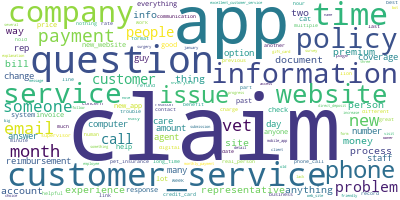

In [380]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=5, prefer_horizontal=1.0, contour_color='steelblue')
wordcloud.generate(bag_words)
wordcloud.to_image()

In [326]:
to_dict = gensim.corpora.Dictionary(final_docs)
corpus = [to_dict.doc2bow(doc) for doc in final_docs]
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=to_dict,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=500,
                                           passes=10,
                                           alpha='auto',
                                           eta = 'auto',
                                           per_word_topics=True)

In [327]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
# a measure of how good the model is. lower the better.

# Compute Coherence Score, higher the better
coherence_model_lda = CoherenceModel(model=lda_model, texts=final_docs, dictionary=to_dict, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.754040336817715

Coherence Score:  0.3566051035045439


In [328]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, to_dict)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.124070 -0.057807       1        1  42.323865
0     -0.054793 -0.035421       2        1  21.524979
3      0.006042  0.151246       3        1  20.201213
2      0.172821 -0.058018       4        1  15.949943, topic_info=         Term       Freq      Total Category  logprob  loglift
96    service  43.000000  43.000000  Default  30.0000  30.0000
16        app  97.000000  97.000000  Default  29.0000  29.0000
29   question  48.000000  48.000000  Default  28.0000  28.0000
23    payment  26.000000  26.000000  Default  27.0000  27.0000
240     money  13.000000  13.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
117  anything   4.002495  16.770222   Topic4  -5.1592   0.4030
26    contact   3.473212  13.415430   Topic4  -5.3010   0.4844
41      phone   3.840089  38.200029   Topic4  -5.2006  -0.4616
24       time   3.720457  39.348845   Topic4  -5.2323  -0.5229
103     email   3.637139  30.133315   Topic4  -5.2549  -0.2787

[251 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
20        1  0.063144  account
20        2  0.694585  account
20        3  0.189432  account
291       2  0.567685    agent
291       3  0.354803    agent
...     ...       ...      ...
74        1  0.398288     week
74        3  0.497859     week
341       1  0.799431     word
813       2  0.927696    wrong
257       3  0.767500   yearly

[317 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1, 4, 3])

In [188]:
review_label_by_sents = {}
for i in cs.transformer_label_sentence:
    review_label_by_sents.update(i[0])
review_label_by_sents

{'i prefer to speak to a person,especially when i am paying $200.00 per month!': 'Negative',
 'knowledgeable and professional': 'Positive',
 'i cancelled petplan so this does not apply to me.': 'Negative',
 'thank you,.': 'Positive',
 'i called on monday, and my issue has still not being taken care of.': 'Negative',
 'my attorney is currently composing a letter.': 'Positive',
 'i was charged when i wasnt supposed to': 'Negative',
 "at my age (80) i don't use the computer very much and would not be comfortable filing a claim in this manner": 'Negative',
 "and i'm sure many other seniors feel the same way !": 'Positive',
 "i've said it all.": 'Positive',
 'no response': 'Negative',
 'i dont talk to machines good luck': 'Neutral',
 'my call was never answered.': 'Negative',
 'your customer service representative, ann, is wonderful and very nice, but your app leaves much to be desired.': 'Neutral',
 'i’ve called a few times to pay my bill.': 'Negative',
 'the website was down at the time':

In [192]:
words_re = re.compile("|".join(['(?i)claim', '(?i)file','(?i)filing', '(?i)submit']))

claim_related = {}
for k,v in review_label_by_sents.items():
    if words_re.search(k):
        claim_related[k] = v 

In [194]:
claim_related

{"at my age (80) i don't use the computer very much and would not be comfortable filing a claim in this manner": 'Negative',
 'waiting time for reviewing the claim.': 'Neutral',
 "the best part is i didn't need to follow up on the claim": 'Positive',
 "submit information  claim didn't receive information.": 'Negative',
 'i explain in detail my issue had been requesting a call from claims because i want them to explain denial of my claim again i was promised a call back within the next business date and it didn’t happen.': 'Negative',
 'my claim was sent aug of last year, re sent in november until my daughter help me to send it by app in jan': 'Negative',
 'i’ve been waiting for call back and explanation on why it’s been denied when it was petplan that failed to reply on my claims and follow up even on a simple call back.': 'Negative',
 'no unnecessary communications and easy hassle free claims processing.': 'Positive',
 'submitting our prescription refill claims for our cat': 'Positive

In [196]:
words_re = re.compile("|".join(['(?i)waiting', '(?i)wait']))

waiting_related = {}
for k,v in review_label_by_sents.items():
    if words_re.search(k):
        waiting_related[k] = v

In [197]:
waiting_related

{'waiting time for reviewing the claim.': 'Neutral',
 'no wait time and my question was answered  no feedback': 'Negative',
 'i’ve been waiting for call back and explanation on why it’s been denied when it was petplan that failed to reply on my claims and follow up even on a simple call back.': 'Negative',
 'took me 3 days to wait for the app to work.': 'Negative',
 'i am still waiting for my cheque that they sent incorrectly and said they would correct': 'Negative',
 'we have not received it, but if you wait long enough perhaps we will forget.': 'Neutral',
 'requested password reset and still waiting for the email': 'Negative',
 'i am waiting to see if we get any money back from gus’s': 'Negative',
 'just waiting to hear back': 'Negative',
 'wait the first 2 calls with no agent ever answering the call.': 'Negative',
 'the third time i waited over half an hour to speak to someone that eventually helped me but was very slow & unhelpful.': 'Negative',
 'it would be nice for canadian cust

In [205]:
words_re = re.compile("|".join(['(?i)customer service', '(?i)customer support']))

customerservice_related = {}
for k,v in review_label_by_sents.items():
    if words_re.search(k):
        customerservice_related[k] = v

In [206]:
customerservice_related

{'your customer service representative, ann, is wonderful and very nice, but your app leaves much to be desired.': 'Neutral',
 'because, the customer service was outstanding.': 'Positive',
 "i don't remember anything like the digital customer service?": 'Negative',
 'your website is not working correctly and i had to google the number as it is not on the site then speak to customer service.': 'Negative',
 'it looks clumsy and seems designed to reduce the amount of customer support you are offering.': 'Neutral',
 'customer service was very friendly and helpful on what questions i had': 'Positive',
 'your customer service is awful.': 'Negative',
 'when i called customer service': 'Negative',
 "it shouldn't matter if petplan customer service is close.": 'Neutral',
 'every time i have called petplan the customer service representatives have been extremely kind and helpful.': 'Positive',
 'these are rare qualities in the customer service industry nowadays, especially via the phone.': 'Posit

In [202]:
words_re = re.compile("|".join(['(?i)\\bapp\\b', '(?i)application']))

app_related = {}
for k,v in review_label_by_sents.items():
    if words_re.search(k):
        app_related[k] = v

In [203]:
app_related

{'your customer service representative, ann, is wonderful and very nice, but your app leaves much to be desired.': 'Neutral',
 'my claim was sent aug of last year, re sent in november until my daughter help me to send it by app in jan': 'Negative',
 'using the app was easy i had to go on the app to switch to direct deposit reimbursement.': 'Neutral',
 'you open the app then it closes out immediately,  takes about 2-3 times to stay in the app,  thoroughly disgusted': 'Negative',
 'the other app worked great .': 'Positive',
 "but i couldn't download the app for my mobile.": 'Negative',
 'i was repeatedly unable to upload documents and because of the app not working, the documents didnt get submitted in time.': 'Negative',
 'took me 3 days to wait for the app to work.': 'Negative',
 'your app was faulty.': 'Negative',
 "the app doesn't work well when i try to submit a claim.": 'Negative',
 "when i call petplan for help, their excuse is that the app doesn't work after their work hours.": '

In [210]:
words_re = re.compile("|".join(['(?i)\\bweb\\b', '(?i)website']))

web_related = {}
for k,v in review_label_by_sents.items():
    if words_re.search(k):
        web_related[k] = v

In [386]:
words_re = re.compile('(?i)real\\b')

real_related = {}
for k,v in review_label_by_sents.items():
    if words_re.search(k):
        real_related[k] = v

In [387]:
real_related

{'there is no substitute for speaking to a real live human.': 'Negative',
 'i appreciate it, when i can speak with a real person.': 'Neutral',
 'but, this time i hard a very hard time getting in touch with a real person to discuss my concerns.': 'Neutral',
 'at least provide a real chat person to deal with if you insist on doing the bot thing that does not answer any questions.': 'Negative',
 "because i am not really all that good on the computer, and it's not a real comfort zone for me": 'Neutral',
 'second, a claim of mine went almost two months with no action on it, and it was nearly impossible to speak to a real person about it.': 'Negative',
 "the real question is 'what's left to like?": 'Neutral',
 'just hate recordings cause it takes too to get to talk to a real person': 'Negative',
 'i like talking to a real person and not pushing 1,2,3 numbers.': 'Positive',
 "when i've always called in the past, i have spoken to a real person,  and i want that to continue!": 'Positive',
 'i h

In [211]:
web_related

{'the website was down at the time': 'Negative',
 'your new “improved “ website is not as easy to navigate as it shove.': 'Neutral',
 'i had no problems with the old website': 'Positive',
 'your website is not working correctly and i had to google the number as it is not on the site then speak to customer service.': 'Negative',
 'one of the main reasons why i have used petplan over many years is that if i have an issue and cannot use the website, i know that i can immediately reach out and speak to someone located in the us.': 'Neutral',
 'website was difficult to navigate on the computer you could tell that it was meant for mobile': 'Negative',
 'it’s 2021, my grocery store has a more efficient website.': 'Positive',
 'the rework of the web site and claim submittal process was frustrating and very inconvenient at a time when stress levels were already high.': 'Negative',
 'clearly the app and web site did not go through user testing.': 'Negative',
 'contact numbers given on the websit

In [212]:
claims = pd.Series(claim_related.values()).value_counts().sort_index()
waiting = pd.Series(waiting_related.values()).value_counts().sort_index()
customer_service = pd.Series(customerservice_related.values()).value_counts().sort_index()
app = pd.Series(app_related.values()).value_counts().sort_index()
web = pd.Series(web_related.values()).value_counts().sort_index()

In [225]:
claims

Negative    155
Neutral      43
Positive     75
dtype: int64

In [223]:
topics = pd.DataFrame([claims, waiting, customer_service, app, web])

topics.index =['Claims', 'Waiting', 'Customer_Service', 'App', "Web"]
topics
topics.to_csv('petplan.csv')

In [224]:
topics

,Negative,Neutral,Positive
Claims,155,43,75
Waiting,17,6,5
Customer_Service,35,13,34
App,88,15,18
Web,49,9,16


In [218]:
value = np.array([app.values, web.values, claims.values, waiting.values, customer_service.values]).transpose()
value

array([[ 88,  49, 155,  17,  35],
       [ 15,   9,  43,   6,  13],
       [ 18,  16,  75,   5,  34]], dtype=int64)

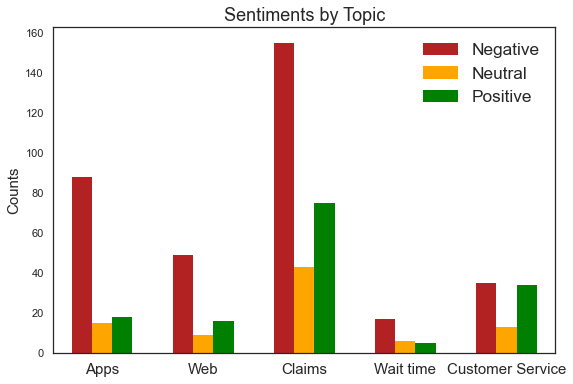

In [221]:
plt.style.use('seaborn-ticks')

plt.figure(figsize=(9,6), facecolor='w')

plt.tick_params(
    axis='both',          
    which='both',     
    bottom=False,      
    top=False, 
    right = False,
    labelbottom=True)
plt.margins(x=0.04)
ind = np.arange(5) 
width = 0.2       
plt.bar(ind, value[0], width, label='Negative', color = 'firebrick', linewidth = 0)
plt.bar(ind + width, value[1], width, label='Neutral', color = 'orange', linewidth = 0)
plt.bar(ind + width*2, value[2], width, label='Positive', color = 'green', linewidth = 0)

# plt.ylim(0, 1200)
plt.ylabel('Counts', fontsize=15)
plt.title('Sentiments by Topic', fontsize = 18)
plt.xticks(ind + width, ('Apps', 'Web', 'Claims', 'Wait time', 'Customer Service'), fontsize = 15)
# plt.yticks(np.arange(0, 1200, step= 500), fontsize = 15)

plt.legend(fontsize='xx-large')

plt.show()

In [368]:
reviews = [x[0] for x in web_related.items() if x[1] is 'Negative']
docs = text_preprocessing2(reviews)
docs[:5]

[['website', 'down', 'time'], ['website', 'work', 'correctly', 'google', 'number', 'site', 'then', 'speak', 'customer', 'service'], ['website', 'difficult', 'navigate', 'computer', 'could', 'tell', 'mean', 'mobile'], ['rework', 'web', 'site', 'claim', 'submittal', 'process', 'frustrating', 'very', 'inconvenient', 'time', 'when', 'stress', 'level', 'already', 'high'], ['clearly', 'app', 'web', 'site', 'go', 'user', 'testing']]
[['website', 'down', 'time'], ['website', 'work', 'correctly', 'google', 'number', 'site', 'then', 'speak', 'customer', 'service'], ['website', 'difficult', 'navigate', 'computer', 'could', 'tell', 'mean', 'mobile'], ['rework', 'web', 'site', 'claim', 'submittal', 'process', 'frustrating', 'very', 'inconvenient', 'time', 'when', 'stress', 'level', 'already', 'high'], ['clearly', 'app', 'web', 'site', 'go', 'user', 'testing']]


[['website', 'down', 'time'],
 ['website',
  'work',
  'correctly',
  'google',
  'number',
  'site',
  'then',
  'speak',
  'customer',
  'service'],
 ['website',
  'difficult',
  'navigate',
  'computer',
  'could',
  'tell',
  'mean',
  'mobile'],
 ['rework',
  'web',
  'site',
  'claim',
  'submittal',
  'process',
  'frustrating',
  'very',
  'inconvenient',
  'time',
  'when',
  'stress',
  'level',
  'already',
  'high'],
 ['clearly', 'app', 'web', 'site', 'go', 'user', 'testing']]

In [369]:
stopwords_list = stopwords.words('english')
# stopwords_list.extend(['thats', 'fres', 'years', 'best', 'day', 'days','coin', 'coin_base', 'bit','coinbase',
#                            'time','would', 'week', 'anything', 'everything', 'nothing', 'lot'])
final_docs = [[word for word in doc if word not in stopwords_list] for doc in docs]
final_docs = list(bigrams[final_docs])
final_docs = list(trigrams[final_docs])
final_docs = [[word for word in doc if word not in ['wa', 'fres', 'ha', 'u', 'petplan']] for doc in final_docs]

In [370]:
x = []
for idx in range(len(final_docs)):
    for token in final_docs[idx]:
        if '_' in token:
            x.append(token)
freq_list = FreqDist(x)
print('\n-----------------')
freq_list.most_common(50)


-----------------


[('new_website', 11),
 ('web_site', 4),
 ('file_claim', 3),
 ('old_website', 2),
 ('user_friendly', 2),
 ('web_portal', 2),
 ('new_app', 2),
 ('new_web', 2),
 ('customer_service_representative', 2),
 ('customer_service', 1),
 ('could_tell', 1),
 ('regular_website', 1),
 ('non_existent', 1),
 ('last_month', 1),
 ('still_need', 1),
 ('customer_service_rep', 1),
 ('call_back', 1),
 ('work_well', 1)]

In [364]:
bag_words = []
for doc in final_docs:
    bag_words.extend(doc)
freq_list = FreqDist(bag_words)
print('\n-----------------')
freq_list.most_common(10)


-----------------


[('claim', 106),
 ('time', 22),
 ('submit', 21),
 ('submit_claim', 20),
 ('file_claim', 16),
 ('app', 16),
 ('try', 15),
 ('document', 11),
 ('email', 11),
 ('call', 10)]